In [1]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics

import myfm

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_cil(dataset="split"):

    file = "data_train" if dataset != "test" else "sampleSubmission"
    data = pd.read_csv(f'../data/{file}.csv', index_col=0)
    data['user'] = data.index.str.split('_').str[0].str[1:].astype('int32')
    data['movie'] = data.index.str.split('_').str[1].str[1:].astype('int32')
    data.rename(columns={'Prediction': 'rating'}, inplace=True)
    data['rating'] = data['rating'].astype('uint8')
    data = data[['user', 'movie', 'rating']]

    data['user'] = data['user'] - 1
    data['movie'] = data['movie'] - 1
    print("Subtracted {} from user and movie".format(1))

    user_num = 10000  # int(data['user'].max() + 1)
    movie_num = 1000  # int(data['movie'].max() + 1)
    print("User num: {}, Movie num: {}".format(user_num, movie_num))

    train_data = val_data = None
    if dataset == "test":
        val_data = data
    elif dataset == "train":
        train_data = data
    else:
        train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    return train_data, val_data, user_num, movie_num

In [6]:
train_data, val_data, user_num, movie_num = load_cil("split")

Subtracted 1 from user and movie
User num: 10000, Movie num: 1000


In [7]:
train_data

,user,movie,rating
Id,,,
r5874_c663,5873,662,5
r4711_c367,4710,366,4
r2539_c435,2538,434,1
r7737_c558,7736,557,2
r9631_c791,9630,790,5
...,...,...,...
r154_c93,153,92,5
r8740_c214,8739,213,5
r9123_c109,9122,108,2


In [80]:
FM_RANK = 10

FEATURE_COLUMNS = ['user', 'movie']
ohe = OneHotEncoder(handle_unknown='ignore')

X_train = ohe.fit_transform(train_data[FEATURE_COLUMNS])
X_test = ohe.transform(val_data[FEATURE_COLUMNS])
y_train = train_data.rating.values
y_test = val_data.rating.values

fm = myfm.MyFMRegressor(rank=FM_RANK, random_seed=42)
fm.fit(X_train, y_train, n_iter=200, n_kept_samples=200)

prediction = fm.predict(X_test)
rmse = ((y_test - prediction) ** 2).mean() ** .5
mae = np.abs(y_test - prediction).mean()
print(f'rmse={rmse}, mae={mae}')

alpha = 1.14 w0 = 3.62 : 100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


rmse=0.9823023913052132, mae=0.788574688813472


In [81]:
fm_grouped = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped.fit(
    X_train, y_train, n_iter=200, n_kept_samples=200,
    group_shapes=[len(group) for group in ohe.categories_]
)

prediction_grouped = fm_grouped.predict(X_test)
rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_grouped).mean()
print(f'rmse={rmse}, mae={mae}')

alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:35<00:00,  5.64it/s]


rmse=0.9797950564318666, mae=0.783828624005537


# Get predictions for test set, train on all data

In [82]:
train_data.shape

(941561, 3)

In [83]:
train_data_full, _, user_num, movie_num = load_cil("train")

Subtracted 1 from user and movie
User num: 10000, Movie num: 1000


In [85]:
_, test_data, user_num, movie_num = load_cil("test")

Subtracted 1 from user and movie
User num: 10000, Movie num: 1000


In [87]:
FM_RANK = 10

FEATURE_COLUMNS = ['user', 'movie']
ohe = OneHotEncoder(handle_unknown='ignore')

X_train_full = ohe.fit_transform(train_data_full[FEATURE_COLUMNS])
X_test_final = ohe.transform(test_data[FEATURE_COLUMNS])
y_train_full = train_data_full.rating.values

fm_grouped = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped.fit(
    X_train_full, y_train_full, n_iter=200, n_kept_samples=200,
    group_shapes=[len(group) for group in ohe.categories_]
)

prediction_test = fm_grouped.predict(X_test_final)

alpha = 1.13 w0 = 3.79 : 100%|██████████| 200/200 [00:29<00:00,  6.87it/s]


In [91]:
test_data['Prediction'] = prediction_test
test_data['Prediction'].to_csv(f"../lightning_logs/BFM/predictions_test.csv")

# Make own predictions to recover std

In [18]:
fm_grouped.V_samples.shape

(200, 11000, 10)

In [19]:
fm_grouped.w0_samples.shape

(200,)

In [20]:
fm_grouped.w_samples.shape

(200, 11000)

In [48]:
# get all predictions

number_of_samples = fm_grouped.w0_samples.shape[0]
prediction_matrix_samples = np.zeros((number_of_samples, 10000, 1000))
for sample in range(fm_grouped.w0_samples.shape[0]):
    # make all shape 10000 x 1000
    w0 = np.ones((10000, 1000)) * fm_grouped.w0_samples[sample]

    user_bias = fm_grouped.w_samples[sample][:10000]
    user_bias = np.repeat(user_bias, 1000).reshape(10000, 1000)

    movie_bias = fm_grouped.w_samples[sample][10000:]
    movie_bias = np.tile(movie_bias, 10000).reshape(10000, 1000)

    interaction = np.dot(fm_grouped.V_samples[sample][:10000], fm_grouped.V_samples[sample][10000:].T)

    prediction_matrix_samples[sample] = w0 + user_bias + movie_bias + interaction

In [49]:
prediction_matrix_samples[:, 5205, 155].mean()

4.953503362099181

In [38]:
# get single prediction

def make_prediction(user, movie, w0_samples, w_samples, V_samples):
    predictions = []
    for i in range(w0_samples.shape[0]):
        w0 = w0_samples[i]
        user_bias = w_samples[i][user]
        movie_bias = w_samples[i][10000 + movie]
        u = V_samples[i][user]
        v = V_samples[i][10000 + movie]
        prediction = w0 + user_bias + movie_bias + np.dot(u, v)
        predictions.append(prediction)
    prediction = np.mean(predictions)
    std = np.std(predictions)
    return prediction, std

In [41]:
make_prediction(5205, 155, fm_grouped.w0_samples, fm_grouped.w_samples, fm_grouped.V_samples)

(4.953503362099181, 0.13172379543663)

In [50]:
val_data['prediction'] = prediction_matrix_samples[:, val_data['user'], val_data['movie']].mean(axis=0)
val_data['std'] = prediction_matrix_samples[:, val_data['user'], val_data['movie']].std(axis=0)

In [51]:
val_data

,user,movie,rating,prediction,std
Id,,,,,
r5062_c706,5061,705,2,3.457201,0.254181
r9044_c148,9043,147,4,3.957705,0.176798
r1736_c169,1735,168,4,4.152227,0.208818
r5270_c877,5269,876,1,3.837557,0.280618
r6100_c691,6099,690,4,3.787237,0.271408
...,...,...,...,...,...
r1990_c61,1989,60,5,4.023024,0.151111
r3900_c177,3899,176,3,3.915896,0.210532
r8964_c860,8963,859,4,3.371252,0.291268


In [34]:
prediction_grouped

array([3.45720082, 3.95770474, 4.15222742, ..., 3.37125229, 4.53651806,
       3.63612183])

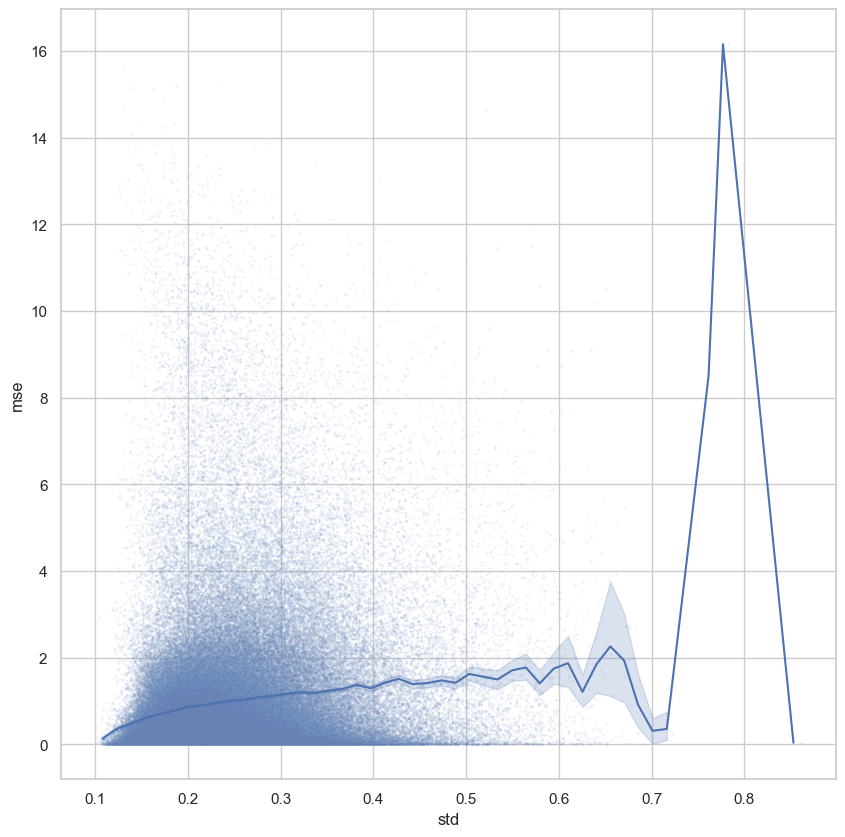

In [77]:
# plot scatter plot of mse by std
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

val_data['mse'] = (val_data['rating'] - val_data['prediction']) ** 2

plt.figure(figsize=(10, 10))
sns.scatterplot(data=val_data, x="std", y="mse", alpha=0.1, s=3)

# bin by std and compute mean mse in each bin and plot
val_data['std_bin'] = pd.cut(val_data['std'], bins=50)
val_data['std_bin'] = val_data['std_bin'].apply(lambda x: x.mid)
sns.lineplot(data=val_data, x="std_bin", y="mse")

plt.show()

<Figure size 1000x1000 with 0 Axes>

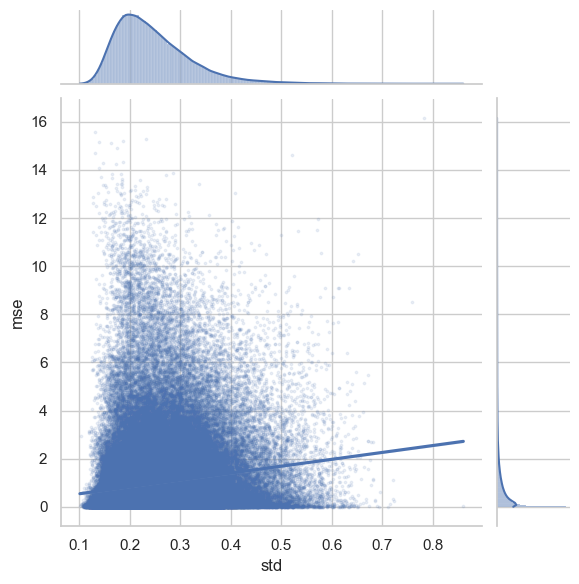

In [76]:
plt.figure(figsize=(10, 10))
sns.jointplot(data=val_data, x="std", y="mse", kind="reg", scatter_kws={"s": 3, "alpha": 0.1})
plt.show()